In [1]:
import tensorflow as tf
import os

In [31]:
from utils.utils import compute_accuracy, compute_loss
from Models.U_net_tf import RSUNet
#working_dir=os.path.dirname(os.path.abspath(__file__))
# Paths
image_path = 'Data/pred/blur/10345.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = image * 2 - 1
image = tf.expand_dims(image, axis=0)
image.shape

TensorShape([1, 512, 512, 3])

In [3]:
def anti_norm(x,to_255=True):
    if to_255:
        return (255*(x+1.0)/2.0).astype(int)
    else:
       return (x+1.0)/2.0

In [4]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) 

In [5]:
checkpoint_name='newnodes'
checkpoint_path = os.path.join("Checkpoints",checkpoint_name) # "./Checkpoints/best_model"
prediction_batch_size=32
# Load the model
model = RSUNet(layers=5, filters=[16,32, 64, 128, 256, 256], output_channels=3)
model.compile(optimizer=optimizer, loss=compute_loss, metrics=[compute_accuracy])
model.load_weights(checkpoint_path)



2024-01-18 17:12:49.352572: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open Checkpoints/newnodes: FAILED_PRECONDITION: Checkpoints/newnodes; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2024-01-18 17:12:51.263291: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2024-01-18 17:12:52.059585: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 17:12:52.060540: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 17:12:52.060557: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-18 17:12:52.061394: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 17:12:52.061454: W tensorflo

1/1 [==============================] - 3s 3s/step


In [32]:
result_tf=model.predict(image)
result_tf=anti_norm(result_tf)

1/1 [==============================] - 0s 70ms/step


In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpigrylfjn/assets


INFO:tensorflow:Assets written to: /tmp/tmpigrylfjn/assets
2024-01-18 17:13:06.402890: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-01-18 17:13:06.402930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-01-18 17:13:06.403127: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpigrylfjn
2024-01-18 17:13:06.420812: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-01-18 17:13:06.420835: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpigrylfjn
2024-01-18 17:13:06.476266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-01-18 17:13:06.491173: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-01-18 17:13:06.745117: I tensorflow/cc/saved_model/loader.cc:212] Running initializatio

# Load and run a model in python

In [8]:
interpreter = tf.lite.Interpreter('model.tflite')

In [9]:
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [11]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 512, 512,   3], dtype=int32),
  'shape_signature': array([ -1, 512, 512,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [33]:
# Test the model on random input data.
input_data = image
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])


In [34]:
output_data=anti_norm(output_data)

In [43]:
import numpy as np
equivelance=(output_data== result_tf)
equivelance.sum(),512*512*3, -(equivelance.sum()-512*512*3)

(786349, 786432, 83)

In [42]:
np.sum(np.abs(output_data-result_tf))/(512*512*3)

0.00010553995768229167

Text(0.5, 1.0, 'tf results')

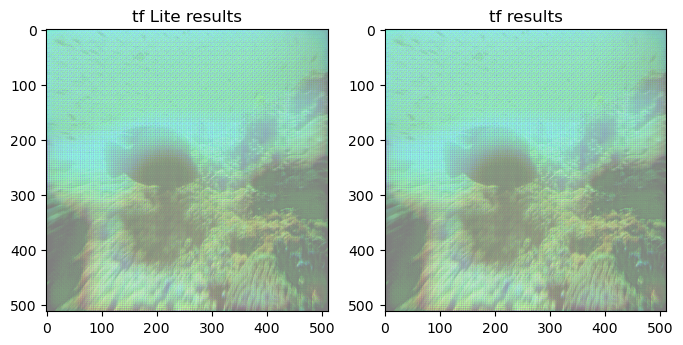

In [36]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 2, figsize=(8,8))
axes[0].imshow(output_data[0])
axes[0].set_title('tf Lite results')
axes[1].imshow(result_tf[0])
axes[1].set_title('tf results')
